<a href="https://colab.research.google.com/github/hyang0129/NGAFIDDATASET/blob/main/NGAFID_DATASET_MINIROCKET_EXAMPLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.13


In [2]:
!git clone https://github.com/hyang0129/NGAFIDDATASET.git

!(cd NGAFIDDATASET ; git checkout main; git reset --hard HEAD; git pull)
!(cd NGAFIDDATASET ; pip install -r requirements.txt -q)

!pip install tsai -q 

fatal: destination path 'NGAFIDDATASET' already exists and is not an empty directory.
Already on 'main'
Your branch is up to date with 'origin/main'.
HEAD is now at a2d7377 Merge remote-tracking branch 'origin/main'
Already up to date.


In [3]:
%load_ext autoreload


In [4]:
import sys 
sys.path.append('/content/NGAFIDDATASET')

In [5]:
%autoreload
from ngafiddataset.dataset.dataset import NGAFID_Dataset_Manager
from ngafiddataset.utils import connect_to_tpu

from tsai.basics import *
from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *
import pandas as pd 


# strategy = connect_to_tpu()

/content/NGAFIDDATASET/ngafiddataset/dataset/dataset.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:

dm = NGAFID_Dataset_Manager('2days')
df = pd.read_csv('/content/2days/flight_header.csv', index_col = 'Master Index')

dm.data_dict =  dm.construct_data_dictionary(numpy=True) 


2022-06-08 21:28:32.326 | INFO     | ngafiddataset.dataset.dataset:download:39 - Extracting File


  0%|          | 0/11446 [00:00<?, ?it/s]

In [7]:
df.head(5)

,before_after,date_diff,flight_length,label,hierarchy,fold,class,target_class,hclass
Master Index,,,,,,,,,
1,1,-1,4723.0,intake gasket leak/damage,NaN,0,10,10,0
2,1,-2,4649.0,intake gasket leak/damage,NaN,0,10,10,0
7,0,1,3482.0,intake gasket leak/damage,NaN,0,10,0,0
9,1,-1,4979.0,intake gasket leak/damage,NaN,0,10,10,0
11,0,2,5204.0,intake gasket leak/damage,NaN,0,10,0,0


In [8]:
number_classes = len(dm.flight_header_df['class'].unique())
number_classes

number_hierarchies = len(dm.flight_header_df['hclass'].unique())
number_hierarchies


5

In [9]:
from fastai.vision import *

In [10]:

from fastai.callback.progress import CSVLogger

# from fastai.callbacks import CSVLogger
from tqdm.autonotebook import tqdm 

  0%|          | 0/5 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.989959,2.983958,0.169432,00:01
1,2.982102,2.971473,0.210917,00:00
2,2.973834,2.966684,0.218341,00:00
3,2.965593,2.958263,0.241048,00:00
4,2.960512,2.970539,0.226201,00:00
5,2.952439,2.949320,0.259389,00:00
6,2.945423,2.949672,0.258515,00:00
7,2.937503,2.948916,0.257205,00:00
8,2.929572,2.946749,0.262882,00:00
9,2.918471,2.950611,0.258515,00:00


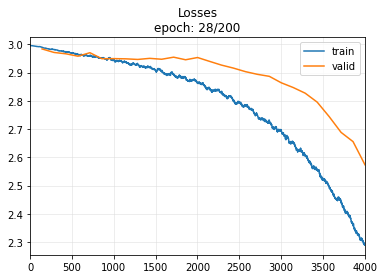

In [ ]:
save_path = '.'
model_name = 'MINIROCKET_MULTI'


for fold in tqdm(range(5)): 
        
    mode = 'before_after'
    mode = 'classes'

    save_filename = save_path + '%s_%i' % (model_name, fold)

    train_dict = dm.get_numpy_dataset(fold = fold, training = True)
    test_dict = dm.get_numpy_dataset(fold = fold, training  = False)


    train_X = np.array(train_dict['data'], dtype = np.float32)

    train_X = (train_X - dm.mins)/(dm.maxs - dm.mins)
    train_X = np.nan_to_num(train_X, copy = False)

    test_X = np.array(test_dict['data'], dtype = np.float32)
    test_X = (test_X- dm.mins)/(dm.maxs - dm.mins)
    test_X = np.nan_to_num(test_X, copy = False)

    train_Y = np.array(train_dict['target_class'])
    test_Y = np.array(test_dict['target_class'])

    # train_Y = np.array(train_dict['before_after'])
    # test_Y = np.array(test_dict['before_after'])

    splits = [list(np.arange(len(train_Y)))]

    splits.append(list(np.arange(len(test_Y) )+ len(train_Y)))


    torch.cuda.empty_cache()
    mrf = MiniRocketFeatures(train_X.shape[1], train_X.shape[2]).to(default_device())
    chunksize = 64

    mrf.fit(train_X, chunksize = chunksize)

    X_feat = get_minirocket_features(np.concatenate([train_X, test_X]), mrf, chunksize=chunksize, to_np=True)
    X_feat.shape

    Y = np.concatenate([train_Y, test_Y])

    PATH = Path("./models/MRF.pt")
    PATH.parent.mkdir(parents=True, exist_ok=True)
    torch.save(mrf.state_dict(), PATH)

    tfms = [None, TSClassification()]
    batch_tfms = TSStandardize(by_sample=True)
    dls = get_ts_dls(X_feat, Y , splits = splits, tfms=tfms, batch_tfms=batch_tfms)
    model = build_ts_model(MiniRocketHead, dls=dls)



    learn = Learner(dls, model, metrics=accuracy, cbs=[ShowGraph(), CSVLogger(save_filename)])          

    results = learn.fit_one_cycle(200, 2.5e-5)